# Welcome to the Geonotebook
GeoNotebook is an application that provides client/server enviroment with inteactive visualization and analysis capabilities using Jupyter notebook, GeoJS and other open source tools.

The example notesbooks in this directory will walk you through several of the features that the ```geonotebook``` plugin to Jupyter makes available. The first thing to know about is...

### The geonotebook object

The ```M``` object is inserted into the kernel automatically once the notebook is started.  This object lives inside the Python kernel's namespace and communicates information to (and receives information from) the GeoJS map. Note that nothing has been imported,  but the ```M``` variable is still available.

**Note:** If you are viewing a static version of this notebook you will NOT see the GeoJS map that is dynamically added to a running notebook.  Please see this [Screen shot](https://raw.githubusercontent.com/OpenGeoscience/geonotebook/master/screenshots/geonotebook.png) to get a sense of the running interface.

In [ ]:
M

### Set the map's center

The M object exposes a number of different functions for interacting with the map (which should be located to the right of standard jupyter python cells).

Executing the following cell should set the center of the map to New York State. 


In [ ]:
# set_center's arguments are latitude,  longitude,  and zoom level
M.set_center(-74, 43, 6)

## What just happened?

It is importaint to understand that ```M.set_center(...)``` is a Python statement being made inside the Python kernel. It is using a remote proceedure call to change the javascript map's location.

The standard Jupyter notebook has three components, (1) the client that makes up the notebook cells, (2) a web server that lists notebook files,  directories and serves notebook assets like HTML and CSS (3) a kernel that executes commands in the chosen language (in our case Python).

![geonotebook simple](https://docs.google.com/drawings/d/1WwUg_nUWkPTsTYTE9Bnjnzu-sIoZh4_PxM4jW7hONiU/pub?w=1440&h=1080)

When you executed the previous cell the string "M.set_center(-74, 43, 6)" was trasmitted over a web socket to the webserver,  then proxied through ZeroMQ to the IPykernel where it was evaluated as a Python expression. This is the standard way in which Jupyter notebook takes code from a web browser,  and executes it in an interactive shell (kernel). M is an object in the kernel,  and it has a function *set_center*.  That function executed and returned a [promise](https://pypi.python.org/pypi/promise),  which is why you see something in the cell output like ```<promise.promise.Promise at 0x7f567dd8f290>```

While the ```set_center``` function returns a promise,  it also has a side effect. This side effect uses a custom jupyter communication channel (or 'Comm') to tell the map to change its view port so the center is at (in this case) -74.0 latitude,  43.0 longitude,  with a zoom level of 6. 

**The importaint take away here is this:** 

    We executed a Python statement which changed the state of the GeoJS Map. 

As we work through these examples we'll see lots of examples of how the Python kernel can inteact with the map and vice-versa.



## Widget example

One question you may immediately ask yourself is,  why not have the notebook cell talk to the map directly?  Why get python involved at all? Well, because ```M.set_center``` is just a Python function,  it can do things like leverage the existing widget extension to the notebook.  

First you must ensure that ```ipywidgets``` extension is [installed](http://ipywidgets.readthedocs.io/en/latest/user_install.html). **If you are running from a virtual environment** the following commands should suffice:

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

If you are **not running in a virtual environment** (e.g. you are running with your globally installed python),  you will need to install the ipywidgets plugin with your system's package manager.  For more instructions check out the [ipywidgets user guide](http://ipywidgets.readthedocs.io/en/latest/)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

def map_widgets(lat=0.0, lon=0.0, zoom=4):
  M.set_center(lat, lon, zoom)
  
interact(map_widgets, lat=(-180.0, 180.0), lon=(-90.0, 90.0), zoom=(1, 9))

# Annotations

In addition to supporting Python to Map communications,  Geonotebook allows objects and events on the map to be communicated back to the Python. One of the primary ways in which this is used is through geonotebook annotations. 

On the toolbar,  next to the "CellToolbar" button,  there should be three additional buttons with a circle,  and square and a polygon. Hovering over each of these reveals that they can be used to start a point, rectangle and polygon annotations. 

### Point annotations
Try clicking on the circle icon. Notice that the cursor,  when it hovers over the map,  is now a cross rather than an arrow. Click on the map and a circle annotation should appear. 

### Rectangle Annotations
Try clicking on the square icon. If you click on the map and hold down the left mouse button, then drag the mouse and release the left mouse button you should be able to create a rectangular annotation. 

### Polygon annotations
Try clicking on the polygon icon.  Single click on a series of points to begin creating a polygon annotation. Double click on a point and the final segment will be added completing the annotation.


Annotations are made available on a special layer under ```M.layers```

In [1]:
M.layers.annotation

<AnnotationLayer('annotation')>

Each of the types of annotations are available under 'points', 'rectangles', and 'polygons' attributes on the AnnotationLayer object

**Note** *Please make sure you have at least one of each annotation on the map*

In [2]:
M.layers.annotation.points

In [3]:
M.layers.annotation.rectangles

In [4]:
M.layers.annotation.polygons

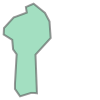

In [8]:
p = M.layers.annotation.polygons[1]
p

In [7]:
# List the exterior coordinates of the annotation
# Expressed in latitude and longitude point pairs
list(p.exterior.coords)

[(34.12902832031249, 15.072123545811671),
 (31.3165283203125, 8.885071663468981),
 (35.57742049945049, 2.9009535226118883),
 (44.36648299945049, 3.9537397000967087),
 (41.55398299945048, 9.017083187429188),
 (36.63210799945048, 8.408951916476422),
 (34.12902832031249, 15.072123545811671)]

Other properties like 'centroid' and 'area' are also available,  keeping in mind that all coordinates are measured in latitude/longitude. This means properties like 'area' will not have much meaning.  You can look at Shapely's [transform](http://toblerity.org/shapely/manual.html#shapely.ops.transform) method for information on how to translate these into to something more useful

In [8]:
list(p.centroid.coords)

[(37.10498989139982, 7.250931205961921)]

In [12]:
import pyproj
import shapely.ops as ops
from functools import partial

project = partial(pyproj.transform,
                  pyproj.Proj(init='EPSG:4326'), 
                  pyproj.Proj(proj='aea',
                    lat1=p.bounds[1],
                    lat2=p.bounds[3]))

ops.transform(project, p).area

130936200300.65767